In [1]:
import os
import torch
import math
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import json
import cv2
import re
import random
import torchvision.transforms as transforms
from torchvision.io import read_image

import matplotlib.pyplot as plt
import torchvision.transforms as T


class PanopticDataset(Dataset):
    def __init__(self, transform, data_set='training'):

        self.data_path = "/Users/olha/unitn/computer_vision/dataset/Panoptic/ProcessedPanopticDataset/"
#         self.data_path = '/media/mmlab/Volume/Panoptic/ProcessedPanopticDataset/'
        self.training_dir = []
        
        self.transform = transform
        
        self.set = data_set

        paths = []

        motion_seq = os.listdir(self.data_path)
        no_dir = ['scripts','python','matlab','.git','glViewer.py','README.md','matlab',
                'README_kinoptic.md']
    
        for dir in motion_seq:
            if dir not in no_dir:
                if 'haggling' in dir:
                    continue
                elif dir == '171204_pose2' or dir =='171204_pose5' or dir =='171026_cello3':
                    if os.path.exists(os.path.join(self.data_path,dir,'hdJoints')):
                        data_path = os.path.join(self.data_path,dir,'hdJoints')
                        for lists in (os.listdir(data_path)):
                            paths.append(os.path.join(data_path,lists.split('.json')[0]))
                elif 'ian' in dir:
                    continue
                else:
                    if os.path.exists(os.path.join(self.data_path,dir,'hdJoints')):
                        print(dir)
                        data_path = os.path.join(self.data_path,dir,'hdJoints')
                        for lists in (os.listdir(data_path)):
                            paths.append(os.path.join(data_path,lists.split('.json')[0]))

        self.data = {'paths': paths}

    def __len__(self):
        return len(self.data['paths'])
    
    def get_second_view(self, image_path):
        split = image_path.split(';')
        camera = split[1].split('_')
        view = int(camera[-1])
        
        second_view = random.randint(0, view) if view > 15 else random.randint(view + 1, 30)
        
        camera[2] = str(second_view) if second_view > 9 else '0' + str(second_view)
        camera = '_'.join(camera)
        split[1] = camera
        second_path = ';'.join(split)
        
        return second_path


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = dict()

        path_split = self.data['paths'][idx].split('/hdJoints')
        image1_path = path_split[0] + '/hdImages' + path_split[-1] + '.jpg'
        image2_path = self.get_second_view(image1_path)
        
        for i in range(0, 10):
            if os.path.isfile(image2_path):
                image2 = cv2.imread(image2_path)
                image2 =cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
                image2 = self.transform(image2)
                break
            else:
                image2_path = self.get_second_view(image1_path)
        else:
            image2 = cv2.imread(image1_path)
            image2 =cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
            image2 = self.transform(image2)
            image2 = T.RandomRotation(45)(image2)
        
        image1 = cv2.imread(image1_path)
        image1 =cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        image1 = self.transform(image1)
        
        sample['image1'] = image1
        sample['image2'] = image2
        
        return sample

In [2]:
def get_dataset(batch_size):
    transforms = T.Compose(
        [
            T.ToTensor(),
            T.Resize(size=(128, 128)),
        ]
    )
    
    dataset = PanopticDataset(transforms)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size)
    
    return dataset, train_loader

In [3]:
def plot_item(data, ind):
    el = data[ind]
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(el['image1'].permute(1, 2, 0))
    ax2.imshow(el['image2'].permute(1, 2, 0))

    plt.show()

171204_pose4
171204_pose3
171026_pose2
171026_pose1


/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


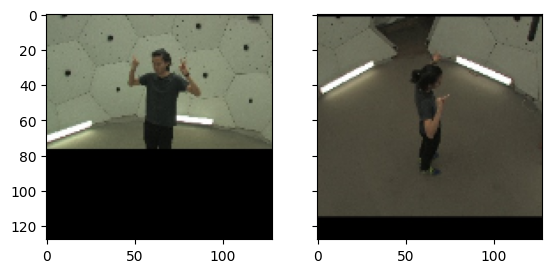

In [4]:
data, loader = get_dataset(443)
plot_item(data, 202)

# SimCLR method

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
from torchvision.models import resnet50, ResNet50_Weights


def get_simclr_net():
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    model.fc = MLP(2048, 2048, 128)

    return model

In [7]:
# !pip3 install pytorch-lightning==1.2.2

In [9]:
from flash.core.optimizers import LARS


def get_optimizer(model, lr, wd, momentum):
    final_layer_weights = []
    rest_of_the_net_weights = []
  
    for name, param in model.named_parameters():
        if name.startswith('fc'):
            final_layer_weights.append(param)
        else:
            rest_of_the_net_weights.append(param)
  
    optimizer = LARS([
        {'params': rest_of_the_net_weights},
        {'params': final_layer_weights, 'lr': lr}
    ], lr=lr / 10, weight_decay=wd, momentum=momentum)

    return optimizer


In [ ]:
import torch.nn.functional as F


def get_loss(geom_encoddings, app_encoddings, t):
    geom_encoddings = F.normalize(geom_encoddings, p=2, dim=1)
    app_encoddings = F.normalize(app_encoddings, p=2, dim=1)
    
    def get_sim(zi, zj, t):
        cosi = torch.nn.CosineSimilarity(dim=1)
        return torch.exp(cosi(zi, zj) / t)
    
    num = get_sim(geom_encoddings, app_encoddings, t)
    num = torch.cat([num, num])
    
    batch = torch.cat([geom_encoddings, app_encoddings])
    batch = batch / batch.norm(dim=1)[:, None]
    sim = torch.mm(batch, batch.transpose(0,1))
    sim = torch.exp(sim / t)
    
    denom = torch.sum(sim, dim=1) - torch.diagonal(sim, 0)
    loss_vec = - torch.log(num / denom)
    
    loss = loss_vec.sum() / batch.size()[0]
        
    return loss


In [20]:
from tqdm import tqdm


def train_step(net, data_loader, optimizer, cost_function, t, device='cuda'):
    samples = 0.
    cumulative_loss = 0.
    net.train()
    
    for batch_idx, batch in enumerate(tqdm(data_loader)):
        
        
        image1 = batch['image1'].to(device)
        image2 = batch['image2'].to(device)

        image1_encoddings = net(image1)
        image2_encoddings = net(image2)

        loss = cost_function(image1_encoddings, image2_encoddings, t)
        loss.backward()

        optimizer.step()

        optimizer.zero_grad()
        
        cumulative_loss += loss.item()
        samples += image1.shape[0]
    
    return cumulative_loss / samples


In [16]:
def main(batch_size=1024, device='cuda:0', learning_rate=0.01, weight_decay=0.000001, momentum=0.9, t=0.6, epochs=10):
    _, train_loader = get_dataset(batch_size)
    
    net = get_simclr_net()
    net.to(device)
    
    optimizer = get_optimizer(net, lr=learning_rate, wd=weight_decay, momentum=momentum)
    
    cost_function = get_loss
    
    for e in range(epochs):
        train_loss = train_step(net, train_loader, optimizer, cost_function, t, device)
        
        print('Epoch: {:d}'.format(e+1))
        print('\tTraining loss {:.5f}'.format(train_loss))
    
    torch.save(net.state_dict(), 'ver0.pt')
    

In [110]:
main(batch_size=200, epochs=20)

In [3]:
class ClusterDataset(Dataset):
    def __init__(self, transform, data_set='training'):

        self.data_path = "/Users/olha/unitn/computer_vision/dataset/Panoptic/ProcessedPanopticDataset/171204_pose3/hdImages"

        images = [os.path.join(self.data_path, f) for f in os.listdir(self.data_path) if os.path.isfile(os.path.join(self.data_path, f))][0:6000]
        self.transform = transform

        self.data = {'paths': images}
    

    def __len__(self):
        return len(self.data['paths'])


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = dict()

        image_path = self.data['paths'][idx]
        
        image = cv2.imread(image_path)
        image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        
        sample['image'] = image
        
        return sample

In [4]:
def get_test_data(batch_size):
    transforms = T.Compose(
        [
            T.ToTensor(),
            T.Resize(size=(128, 128)),
#             T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
        ]
    )
    
    test_dataset = ClusterDataset(transforms)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size)
    
    return test_dataset, test_loader

In [4]:
def extract_representations(path, test_loader, load=True):
    net = get_simclr_net()
    
    if load:
        net.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

    net.to('cpu')
    net.eval()
    
    representations = []
        
    with torch.no_grad():
        for batch_idx, inputs in enumerate(test_loader):
            images = inputs['image']
            images.to('cpu')
            model_out = net(images)
            representations.append(model_out)

    return torch.cat(representations).numpy()

In [5]:
from sklearn.cluster import KMeans


def cluster(features):
    kmeans = KMeans(n_clusters=8)
    kmeans.fit(features)
    
    return kmeans.labels_

In [6]:
from sklearn.decomposition import PCA


def reduce_dim(features):
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)
    
    return pca_features

In [7]:
def plot_clusters(clusters, pca_features):
    colors = {
        0: '#F8512E', 1: '#F8F82E',
        2: '#40F82E', 3: '#2EC1F8',
        4: '#6B2EF8', 5: '#D92EF8',
        6: '#731642', 7: '#092040'
    }
    
    cluster_colors = [colors[c] for c in clusters]
    
    plt.scatter(pca_features[:, 0], pca_features[:, 1], color=cluster_colors)
    plt.show()

In [8]:
def cluster(load=True):
    test_set, test_loader = get_test_data(30)
    
    path = '/Users/olha/unitn/computer_vision/lectures/ver0.pt'
    
    features = extract_representations(path, test_loader)
    
    labels = cluster(features)
    pca = reduce_dim(features)
    
    plot_clusters(labels, pca)
    return test_set, features, labels, pca

## After training (2000)

/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


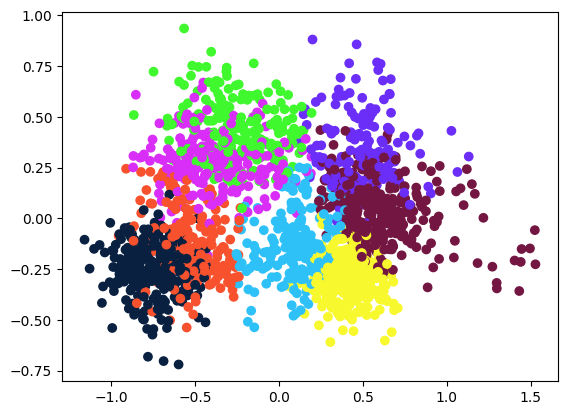

In [92]:
cluster()

## After training (6000)

/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


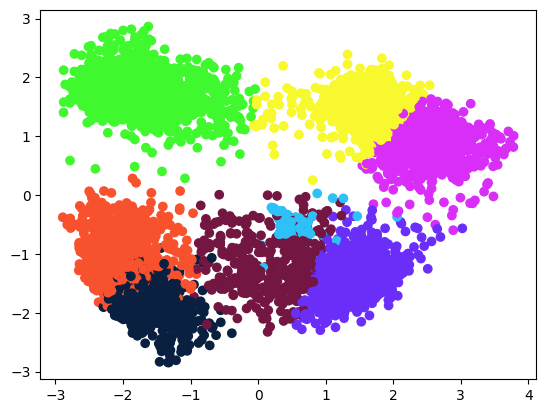

In [21]:
cluster_set, features, labels, pca = cluster()

In [22]:
labels

array([7, 0, 3, ..., 7, 2, 0], dtype=int32)

In [25]:
index_5 = [i for i in range(0, len(labels)) if labels[i]==5]

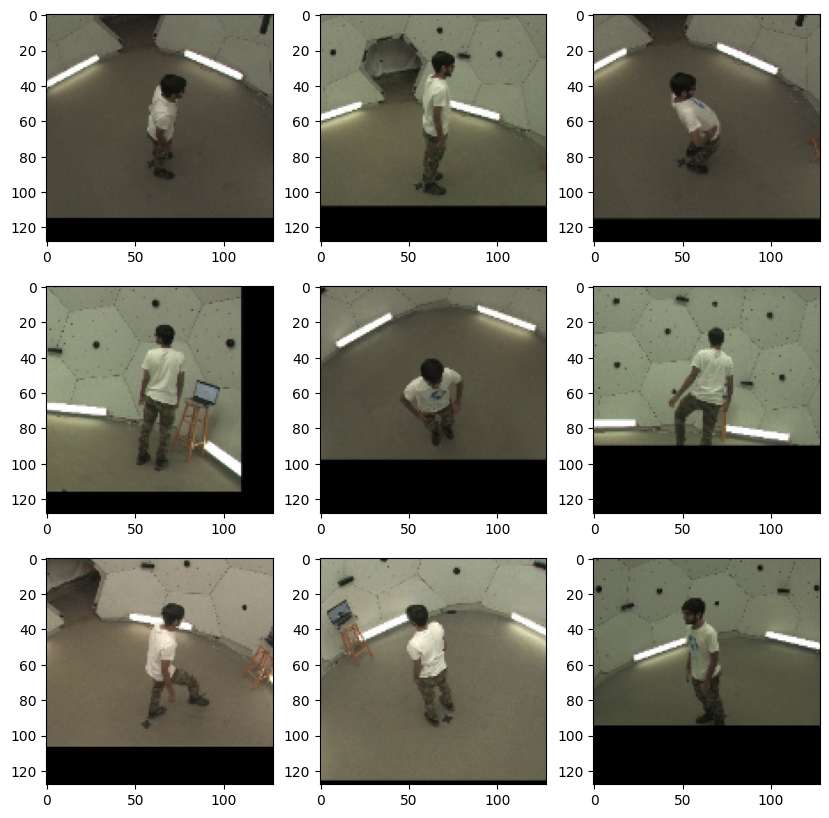

In [57]:
plt.figure(figsize = (10,10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(cluster_set[index_5[i]]['image'].permute(1, 2, 0))

plt.show()

In [34]:
index_2 = [i for i in range(0, len(labels)) if labels[i]==2]

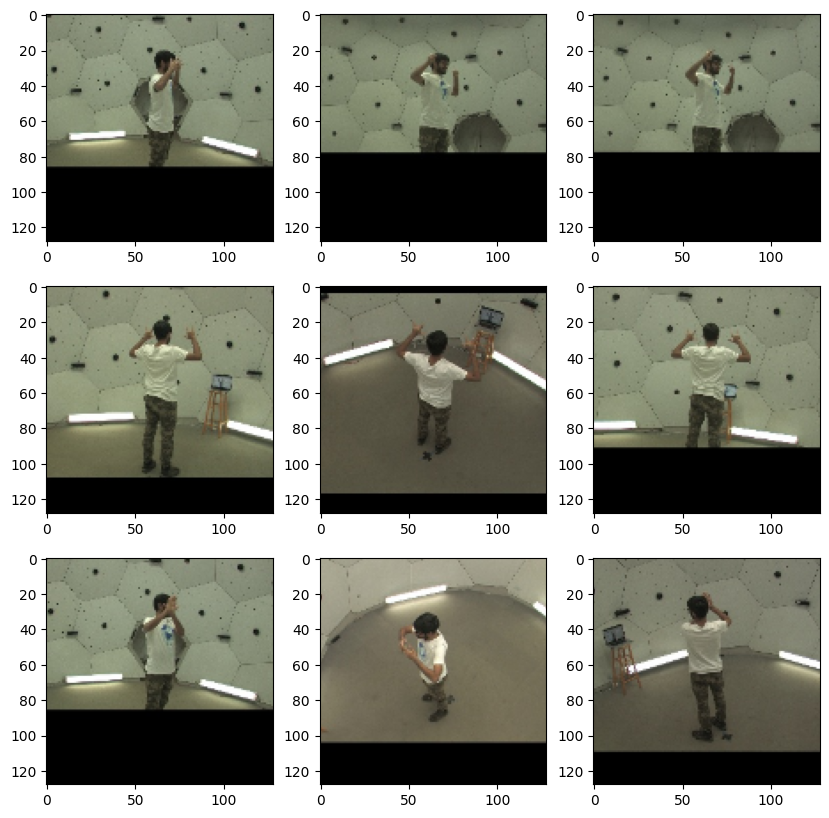

In [58]:
plt.figure(figsize = (10,10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(cluster_set[index_2[i]]['image'].permute(1, 2, 0))

plt.show()

In [44]:
index_7 = [i for i in range(0, len(labels)) if labels[i]==7]

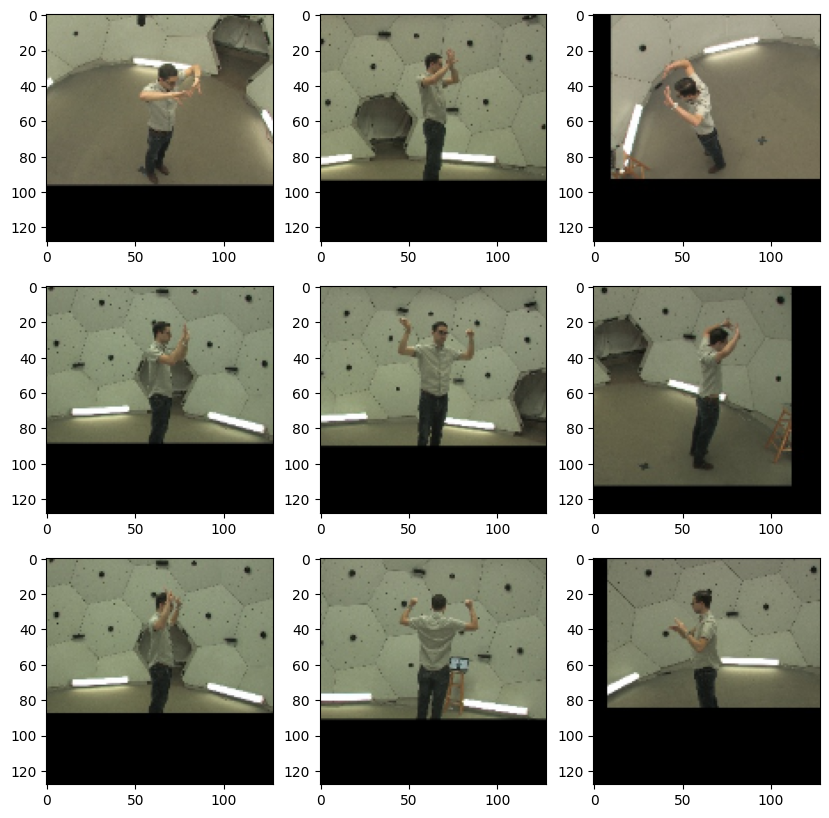

In [59]:
plt.figure(figsize = (10,10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(cluster_set[index_7[i]]['image'].permute(1, 2, 0))

plt.show()

In [40]:
index_3 = [i for i in range(0, len(labels)) if labels[i]==3]

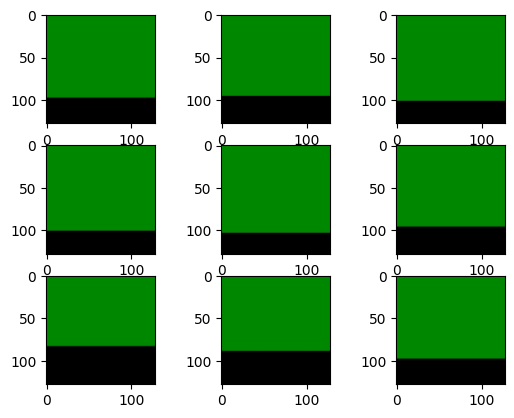

In [63]:
for i in range(0, 9):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(cluster_set[index_3[i]]['image'].permute(1, 2, 0))

plt.show()

In [42]:
index_4 = [i for i in range(0, len(labels)) if labels[i]==4]

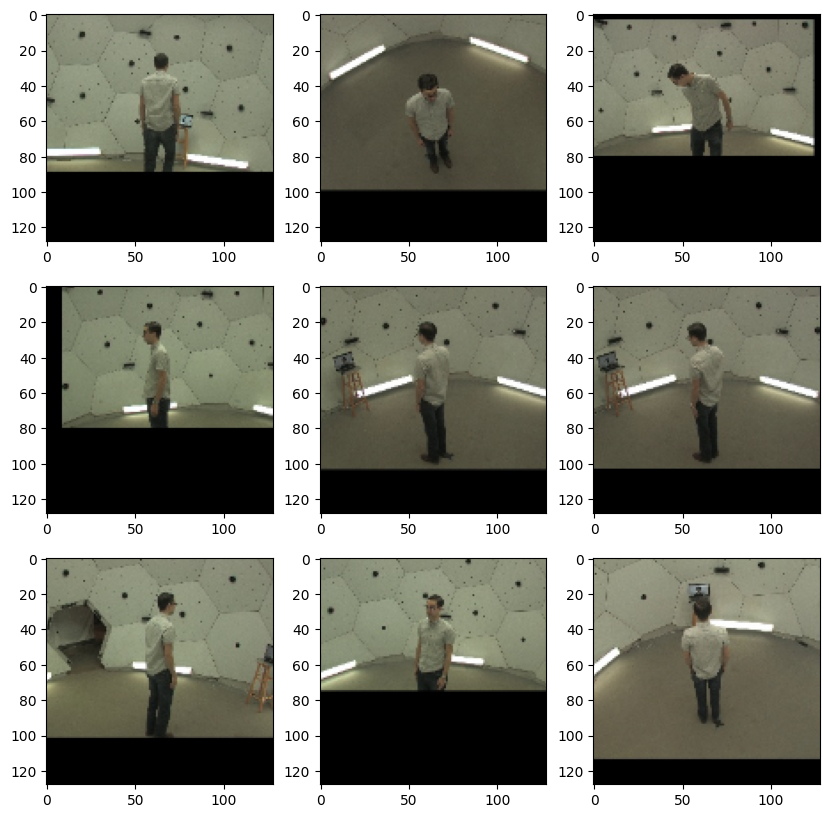

In [60]:
plt.figure(figsize = (10,10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(cluster_set[index_4[i]]['image'].permute(1, 2, 0))

plt.show()

## Before training (2000)

/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


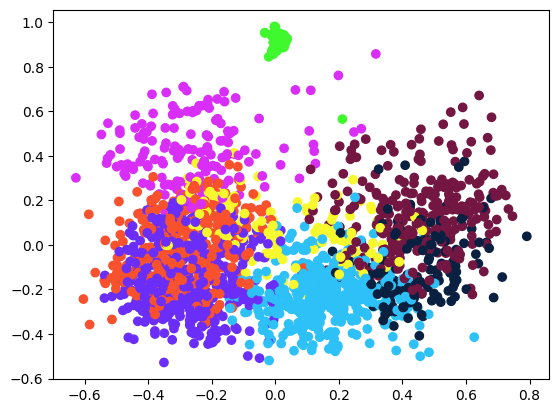

In [101]:
cluster(False)

## Before training (6000)

/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


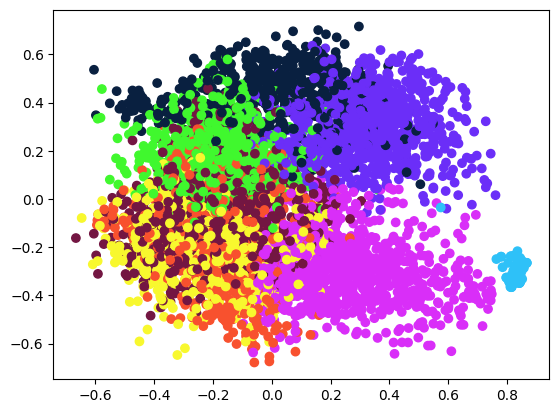

In [118]:
cluster(False)

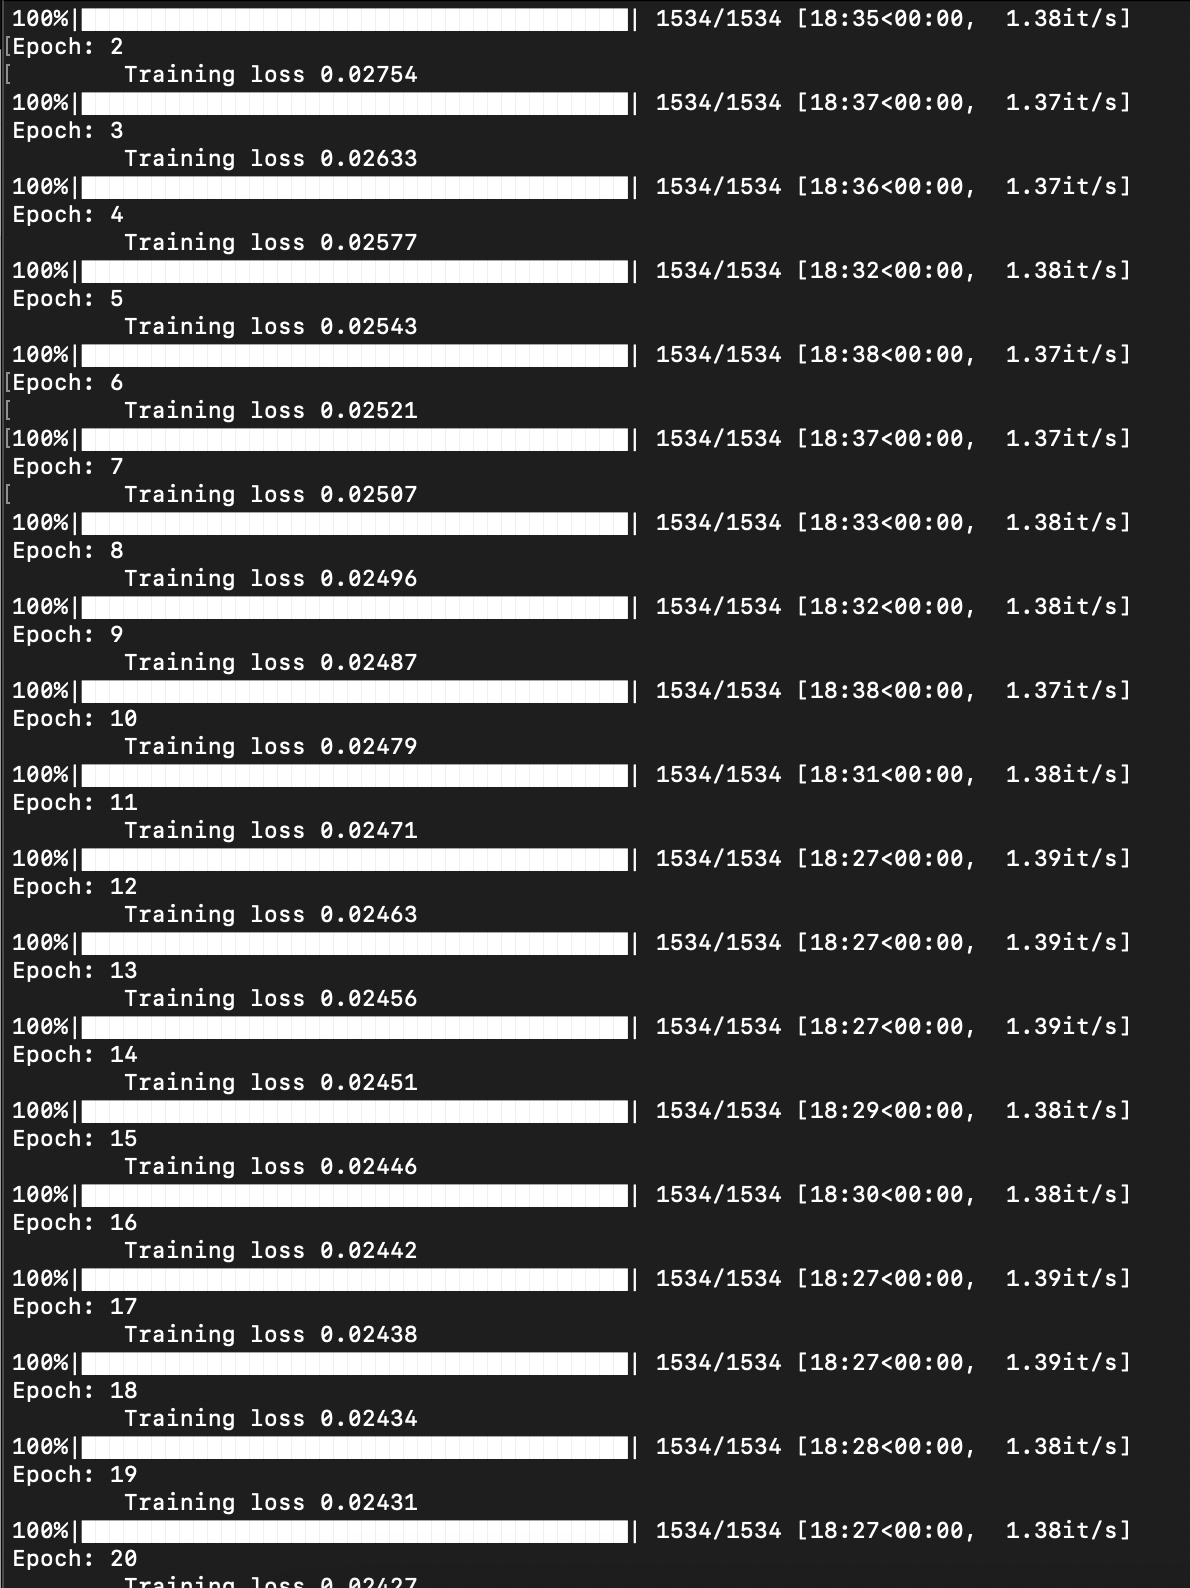

In [124]:
from IPython import display

display.Image("/Users/olha/unitn/computer_vision/cluster_results/Screenshot 2023-05-04 at 15.52.06.png", width=500)

